In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import time
import re
import requests
import json
import tqdm

# Query Parameters

In [2]:
waitSeconds = .05
startTimeString ='2016-07-11 00:00:00'
timeZoneString = 'US/Pacific'
startTime = pd.Timestamp(startTimeString, tz=timeZoneString)
# startTime = pd.to_datetime(startTimeString)
startLocation = "20320 Estuary Lane, Newport Beach, CA"
endLocation = "4640 Admiralty Way, Marina Del Rey, CA"

In [3]:
startTime

Timestamp('2016-07-11 00:00:00-0700', tz='US/Pacific')

In [4]:
startTime.tz_convert('utc')

Timestamp('2016-07-11 07:00:00+0000', tz='UTC')

In [5]:
def queryDirections(apiKey, originAddress, destinationAddress, departureDateTime=None):
    '''Queries the Google directions API given and returns the results as a json object 
    
    Inputs:
    -------
    apiKey - A string containing the Google Directions API key
    originAddress - A string representation of the origin address
    destinationAddress - A string representation of the destination address
    departureDateString - A string representation of time travel will begin in format '%Y-%m-%d %H:%M'
    
    Outputs:
    --------
    queryResult - The json object
    '''
    
    # Declare the main query string
    requestText=str('''https://maps.googleapis.com/maps/api/directions/json?'''
                        '''origin={ORIGIN}&destination={DESTINATION}'''
                        '''&departure_time={DEPARTURE_TIME}'''
                        '''&key={KEY}''')
    
    #...&traffic_model=best_guess
    
    # Clean the address strings
    def cleanAddress(rawString):
        return re.sub(' +', ' ', rawString.strip()).replace(' ', '+')
        
    originParams=cleanAddress(originAddress)
    destinationParams=cleanAddress(destinationAddress)
    
    # Clean the departure time
    def secondsSinceEpoch(departureDateTime):
        dt = departureDateTime.tz_convert('utc')
        epoch = datetime.utcfromtimestamp(0).replace(tzinfo=dt.timetz().tzinfo)
#         epoch = datetime.utcfromtimestamp(0)
        return int((dt - epoch).total_seconds())

    if departureDateTime == None:
        departureTimeParams='''now'''
    else:
        departureTimeParams=secondsSinceEpoch(departureDateTime)
        
    
    query = requestText.format(ORIGIN=originParams, 
                                  DESTINATION=destinationParams,
                                  DEPARTURE_TIME=departureTimeParams,
                                  KEY = apiKey)
#     print(query)
    
    
    # Issue query
    queryResult = requests.get(query)
    
    # Check that result is valid before returning
    assert queryResult.status_code == 200    
    jsonResult = json.loads(queryResult.content.decode())
    
    return (jsonResult)

# Get API key

In [6]:
keyPath = 'D:\data\keys\google-api.apk'

with open(keyPath) as keyFile:
    apiKey = keyFile.read()

# Trip Data from Home to Work, and Work to Home

In [7]:
# Request directions via public transit
#queryDateTime = datetime(2016, 3, 23, 6, 42, 30, 283810, 'PST')
leaveResultsList = []
returnResultsList = []
for day in tqdm.tnrange(0, 5, desc='Day loop'):
    for i in tqdm.tnrange(0, 48, desc='Hour loop'):
        queryDateTime = startTime + pd.Timedelta(days=day) + pd.Timedelta(minutes = 30*i)
        
        # Home to work
        directions_result = queryDirections (apiKey, startLocation, endLocation, departureDateTime=queryDateTime)
        assert directions_result['status'] != 'INVALID_REQUEST', directions_result['error_message']

        leaveResultsList.append([queryDateTime,
                                        directions_result['routes'][0]['legs'][0]['duration']['value'], 
                                        directions_result['routes'][0]['legs'][0]['duration_in_traffic']['value']])
        
        # Work to home
        directions_result = queryDirections (apiKey, endLocation, startLocation, departureDateTime=queryDateTime)
        assert directions_result['status'] != 'INVALID_REQUEST', directions_result['error_message']
        returnResultsList.append([queryDateTime,
                                        directions_result['routes'][0]['legs'][0]['duration']['value'], 
                                        directions_result['routes'][0]['legs'][0]['duration_in_traffic']['value']])
        time.sleep(waitSeconds)

# Clean the data

In [10]:
dfLeaveResult = pd.DataFrame(leaveResultsList)
dfLeaveResult.columns = ['dateTime', 'durationSeconds', 'durationInTrafficSeconds']
dfLeaveResult['durationInTrafficMinutes'] = dfLeaveResult.durationInTrafficSeconds / 60.
dfLeaveResult['dayOfWeekInt'] = dfLeaveResult['dateTime'].dt.dayofweek
dfLeaveResult['dayOfWeekName'] = dfLeaveResult['dateTime'].dt.weekday_name

dfReturnResult = pd.DataFrame(returnResultsList)
dfReturnResult.columns = ['dateTime', 'durationSeconds', 'durationInTrafficSeconds']
dfReturnResult['durationInTrafficMinutes'] = dfReturnResult.durationInTrafficSeconds / 60.
dfReturnResult['dayOfWeekInt'] = dfReturnResult['dateTime'].dt.dayofweek

# Plot travel times

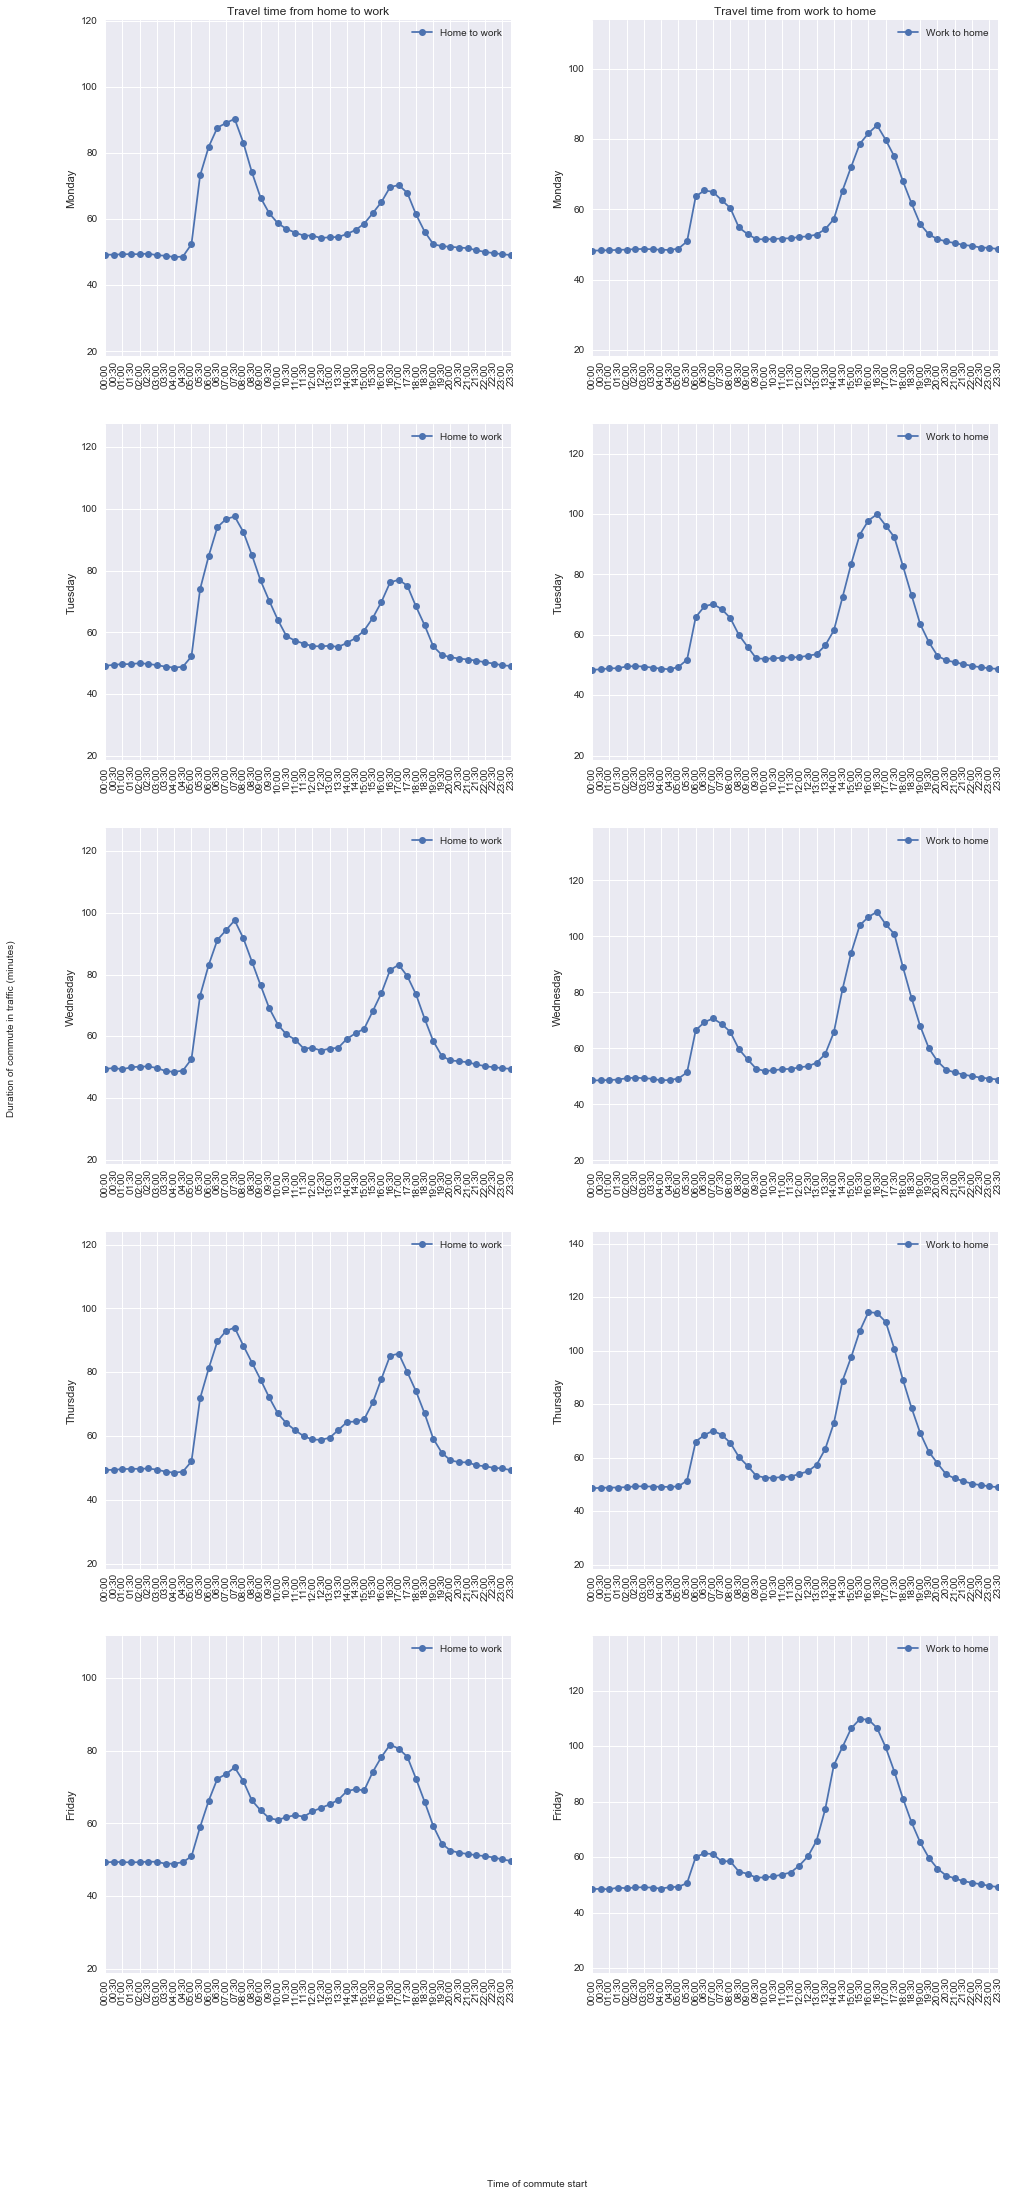

In [92]:
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
%matplotlib inline

tzInfo = dfLeaveResult.loc[0, 'dateTime'].tz
dateFormatter = matplotlib.dates.DateFormatter('%H:%M', tz=tzInfo)

def plotDay(df, ax, label):
    '''Plot the travel time by date
    '''
    # ax.plot_date(pd.to_datetime(plotData.timestampUNIX, unit='s'), plotData.speedOverGround, fmt='-', label=ship)
    ax.plot_date(df['dateTime'], df['durationInTrafficMinutes'], ls='-', marker='o', label=label)
    # ax[0].bar(pd.to_datetime(dfResult.datestring), dfResult.durationInTrafficMinutes, 
    #     width =.01, align='edge')
    # ax.xlabel('Time leaving home')
    # ax.ylabel('Duration in traffic (minutes)')
    
# common aesthetics
def applyCommonAesthetics(df, ax, tzInfo):
    '''Applies aesthetics to the subplot. These aesthetics seem order dependent
    '''
    
    # Locators cannot be shared between axes.
    # The set_major_locator() method assigns its axis to that Locator, 
    # overwriting any axis that was previously assigned.
    majorDateLocator = matplotlib.dates.HourLocator(byhour=range(24), interval=1, tz=tzInfo)
    minorDateLocator = matplotlib.dates.MinuteLocator(byminute=range(10, 50), interval=30, tz=tzInfo)
    
    ax.xaxis.set_major_locator(majorDateLocator)
    ax.xaxis.set_minor_locator(minorDateLocator)
    ax.xaxis.set_major_formatter(dateFormatter)
    ax.xaxis.set_minor_formatter(dateFormatter)
    
#     ax.set_xlabel('%s Time of commute start'% df['dateTime'].dt.weekday_name.tolist()[0])
#     ax.set_ylabel('Duration in traffic (minutes)')
    ax.set_ylabel('%s' % df['dateTime'].dt.weekday_name.tolist()[0])

    ax.set_ylim([df['durationInTrafficMinutes'].min() - 30, df['durationInTrafficMinutes'].max() + 30])
    
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_rotation(90)
    for tick in ax.xaxis.get_minorticklabels():
        tick.set_rotation(90)

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    
    ax.legend(loc='best')
    

listDfData = [dfLeaveResult, dfReturnResult]
labels = ['Home to work', 'Work to home']
days = dfLeaveResult['dayOfWeekInt'].unique()
subplotWidth = 8
subplotHeight = 7

fig, axes = plt.subplots(nrows=len(days), ncols=len(listDfData), 
                         figsize=(subplotWidth*len(listDfData),subplotHeight*len(days)))
for col, dfPlot in enumerate(listDfData):
    for row in days:
        plotDay(dfPlot.loc[dfPlot['dayOfWeekInt'] == row], axes[row][col], labels[col])
        applyCommonAesthetics(dfPlot.loc[dfPlot['dayOfWeekInt'] == row], axes[row][col], tzInfo)

# Specific Aesthetics
axes[0][0].set_title('Travel time from home to work')
axes[0][1].set_title('Travel time from work to home')
fig.text(0.5, 0.04, 'Time of commute start', ha='center')
fig.text(0.04, 0.5, 'Duration of commute in traffic (minutes)', va='center', rotation='vertical')

# fig.autofmt_xdate()

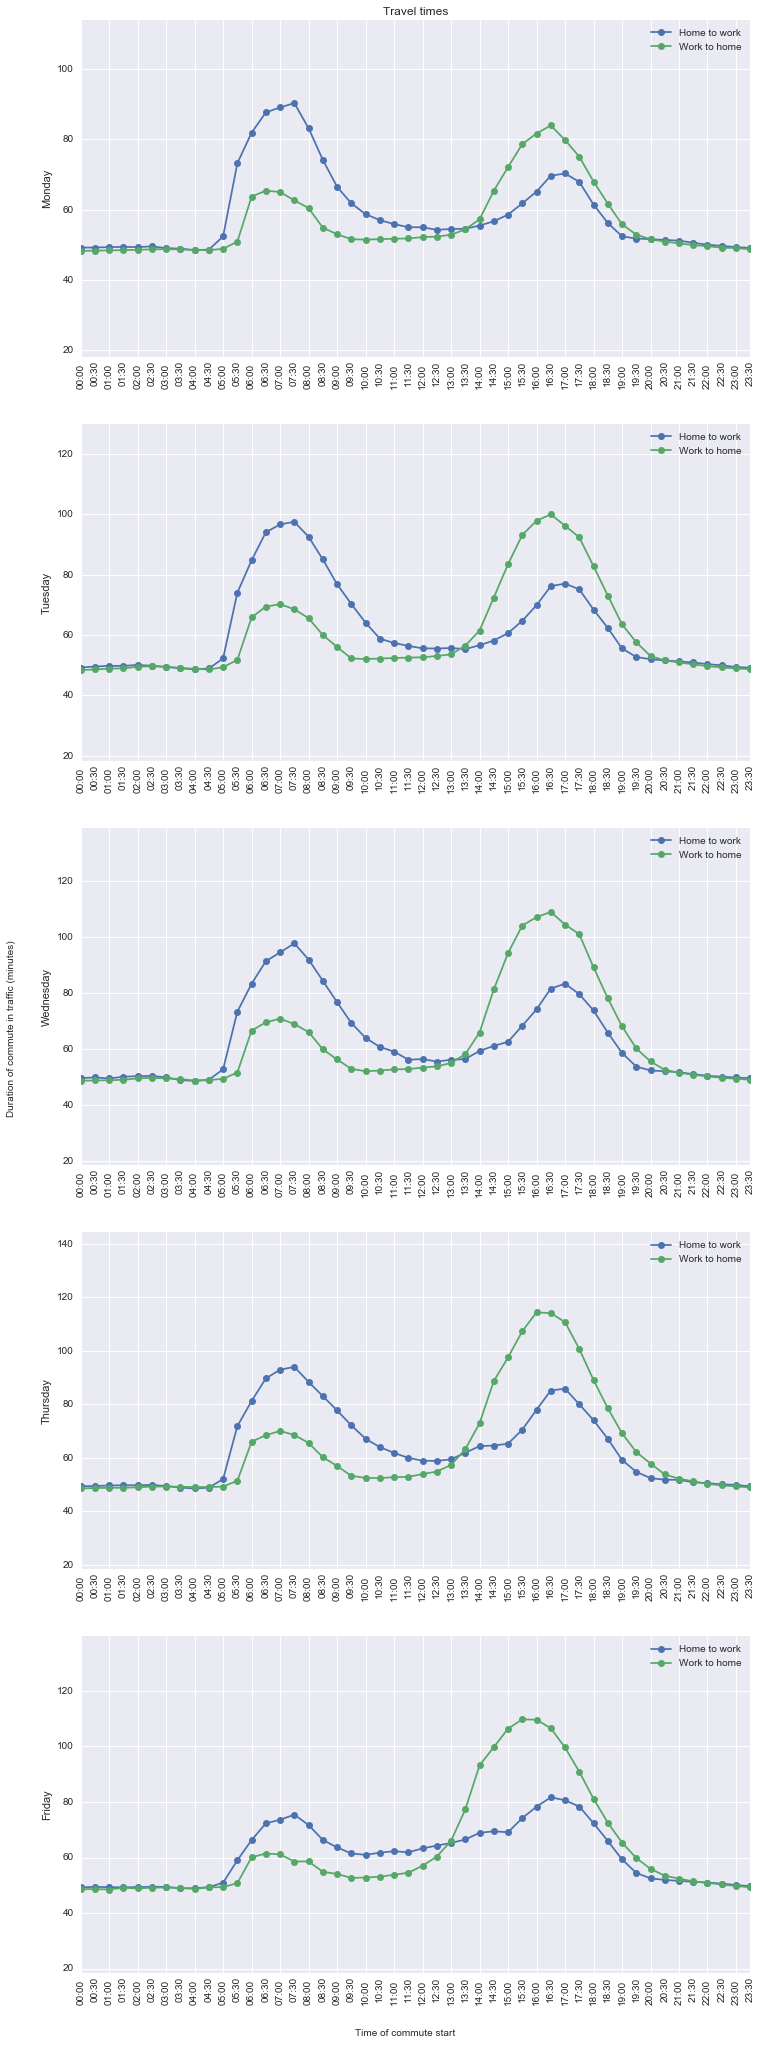

In [96]:
listDfData = [dfLeaveResult, dfReturnResult]
labels = ['Home to work', 'Work to home']
days = dfLeaveResult['dayOfWeekInt'].unique()
subplotWidth = 12
subplotHeight = 7

fig, axes = plt.subplots(nrows=len(days), 
                         figsize=(subplotWidth,subplotHeight*len(days)))
for row in days:
    for i, dfPlot in enumerate(listDfData):
        plotDay(dfPlot.loc[dfPlot['dayOfWeekInt'] == row], 
                axes[row],
               label=labels[i])
        
    applyCommonAesthetics(dfPlot.loc[dfPlot['dayOfWeekInt'] == row], axes[row], tzInfo)

# Specific Aesthetics
axes[0].set_title('Travel times')
fig.text(0.5, 0.1, 'Time of commute start', ha='center')
fig.text(0.04, 0.5, 'Duration of commute in traffic (minutes)', va='center', rotation='vertical')